#Importação das Bases

**Importação das bases e bibliotecas**

Para realização desse projeto vamos utilizar duas bases de dados. Uma que possui os dados dos experimentos que vamos chama-la de ```base_experimentos``` e outra que contêm os dados sobre os mecanimos de ação de cada experimento ```base_moa```.

As principais bibliotecas utilizadas:


*   Pandas: para trabalharmos com os dados das bases.
*   Seaborn e Matplotlib: para construirmos os gráficos.
*   Sklearn: para aplicarmos os algoritmos de aprendizagem de máquina.


In [1]:
import pandas as pd


#urls do github das bases
url_dados_exp = 'https://github.com/SidAraujo/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
url_dados_moa = 'https://github.com/SidAraujo/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true'

base_experimentos = pd.read_csv(url_dados_exp, compression = 'zip')
#renomear coluna droga para composto
mapa = {'droga': 'composto'}
base_experimentos.rename(columns=mapa, inplace=True)

base_moa = pd.read_csv(url_dados_moa)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree


#Sobre os atributos da base de experimentos

Inicialmente vamos iniciar analisando a base de dados dos experimentos. Ao total ela possui 23814 linhas e 877 colunas.


*   Tratamento: informa se o experimento é controle ou um composto.
*   Dose: informa qual dose do composto foi ministrada e possui dois tipos de D1 e D2.
*   Tempo: Referente ao tempo medido no experimento.
*   Composto: que informa qual composto foi utilizado.
*   Expressão Genética: possui a maior quantidade de colunas varaindo de 0 - 771.
*   Viabilidade Celular: segunda maior quantidade de colunas variando de 0 - 99.




In [3]:
print(base_experimentos.shape)
base_experimentos.head()

(23814, 877)


,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


##Expressão Genética e Viabilidade Celular
Para inializarmos as análises temos que entender melhor como se comportam esses dois tipos de atributos presentes na base.

**Expressão Genética**

Expressão Genética o processo pelo qual as instruções em nosso DNA são convertidas em um produto funcional, como uma proteína. Mais informações em [Gene-Expression](https://www.yourgenome.org/facts/what-is-gene-expression).

Nesse caso um composto pode aumentar a expressão genética como também diminuir. Isso pode ser importante na análise dos genes.

Para visualizarmos vamos observar como uma expressão genética ```g-131``` se comporta no grupo de controle e na presença do composto```87d714366```.

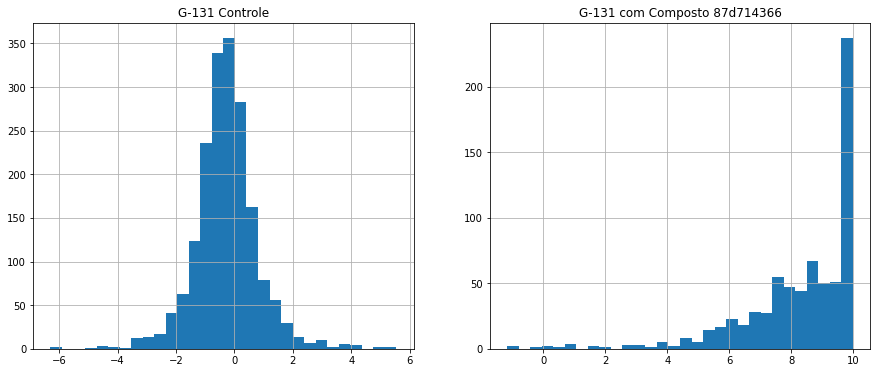

In [4]:
grupo_controle = base_experimentos.loc[base_experimentos['tratamento'] == 'com_controle']

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('G-131 Controle')
grupo_controle['g-131'].hist(bins=30)

plt.subplot(1, 2, 2)
plt.title('G-131 com Composto 87d714366')
base_experimentos.query('composto == "87d714366"')['g-131'].hist(bins=30)

plt.show()

**Viabilidade Celular**

Viabilidade é uma medida da proporção de células vivas saudáveis em uma população. Os ensaios de viabilidade celular são usados para determinar a saúde geral das células, otimizar a cultura ou as condições experimentais e para medir a sobrevivência celular após o tratamento com compostos, como durante uma triagem de drogas. Mais informações sobre [Viabilidade Celular](https://www.cellsignal.com/science-resources/cell-viability-and-survival).

Em algumas definições a viabilidade celular varia entre 0 e 1. Na base utilizada a viabilidade está entre -10 e 6 devido ao método de normalização utilizado. Um valor mais negativo significa um maior número de células mortas e quanto maior o valor da viabilidade maior o número de células vivas.

Podemos verificar isso ao observar os dados do atributo ```c-50``` aplicado ao composto ```87d714366```.

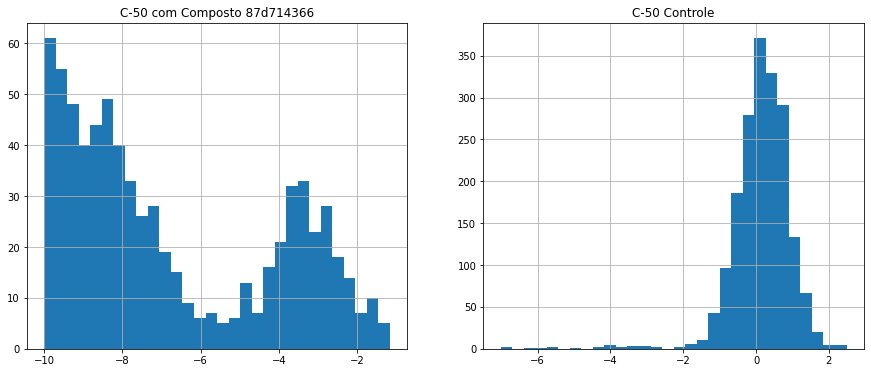

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('C-50 com Composto 87d714366')
base_experimentos.query('composto == "87d714366"')['c-50'].hist(bins=30)

plt.subplot(1, 2, 2)
plt.title('C-50 Controle')
grupo_controle['c-50'].hist(bins=30)

plt.show()

#Hipóteses

Visto como a base de experimentos está formada podemos colocar algumas hipóteses:


*   Se selecionado um composto é possível identificar quais genes tiveram aumento ou diminuição em suas expressões?
*   Quais componentes celulares foram afetados dado um composto.
*   A dose e o tempo influenciam nas expressões genéticas e componentes celulares?
*   É possível identificar que mecanismos de ação foram ativados dado os experimentos de um composto?



#Análises

A base de experimentos possui 3288 compostos, dentre esses 8 compostos possui os maiores dados de experimentos.


Quantidade de compostos: 3289


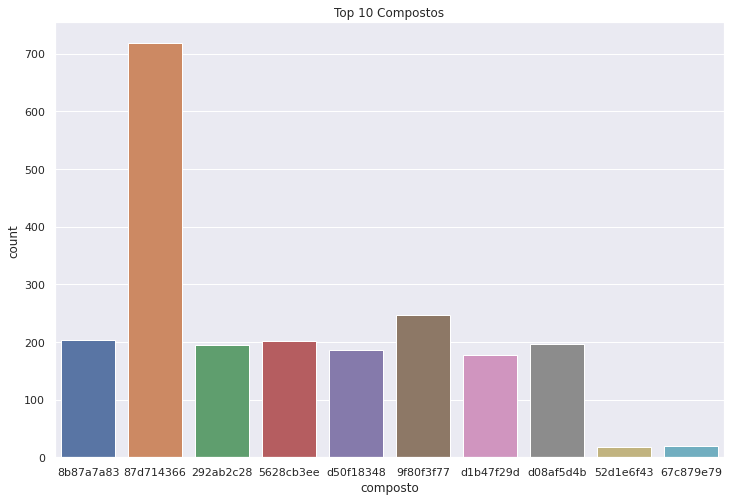

In [6]:
print(f"Quantidade de compostos: {len(base_experimentos['composto'].unique())}")

cod_composto = base_experimentos['composto'].value_counts().index[0:11]
sns.set()
plt.figure(figsize=(12, 8))
ax = sns.countplot(x = 'composto', data=base_experimentos.query('composto in @cod_composto and tratamento == "com_droga"'))
ax.set_title('Top 10 Compostos')
plt.show()


Então para realizar as análise vamos selecionar o composto ```9f80f3f77``` que possui a segunda maior quantidade de elementos igual a 246.

In [7]:
composto_analise = base_experimentos.loc[base_experimentos['composto'] == '9f80f3f77']
composto_analise

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
75,id_00ceee87f,com_droga,24,D2,9f80f3f77,0.1529,0.7548,-0.2295,-0.8523,-0.2514,0.2268,0.0149,-0.1635,1.0450,0.2235,0.1648,0.0141,0.5388,1.0580,0.2015,-0.5861,0.2914,0.8117,-0.1069,-0.7390,0.2541,-0.9008,0.7663,-0.4047,-0.4749,-0.1509,1.6940,-0.7885,1.0320,-0.1178,0.7606,-1.3400,-0.5971,0.7020,-0.2128,...,-0.2844,-0.0754,0.2215,-0.9430,0.5808,-0.3971,0.2051,0.5096,0.2966,-0.6770,0.0015,0.1029,0.7437,0.6183,1.6220,0.9195,1.2210,1.2600,0.7758,-0.1482,-0.3757,0.5976,-0.2748,0.0524,0.7058,-0.2787,0.3502,-0.2542,0.4828,0.8019,1.3040,0.1944,0.4610,0.4769,1.0690,0.8160,0.1111,-0.5638,-0.2188,-0.7164
251,id_02945c933,com_droga,48,D1,9f80f3f77,2.3910,-0.0442,-0.0665,0.1629,-0.8641,-1.6640,-0.0938,-1.3160,-0.3238,-0.5067,0.3137,0.5808,1.2900,2.3890,0.4489,0.0093,0.6986,1.2340,-0.1052,-0.3655,0.4868,0.5458,0.0970,0.4920,-2.3170,0.6171,0.5247,-1.3210,0.1538,-0.2424,0.0222,0.1807,-1.6110,1.6000,2.0900,...,0.2819,0.7115,0.2465,0.0301,-1.7010,-2.2180,2.2830,-0.5045,1.3860,0.4842,0.7068,0.6445,1.3950,0.9436,1.3120,-0.4704,0.4737,-0.6913,1.1240,0.1976,-0.5729,2.0780,1.2380,-0.3703,1.7070,-0.8983,0.5355,0.3853,0.5486,0.5060,-0.1452,-0.9209,-0.6870,-1.6310,1.5310,-0.3261,1.0790,0.7368,-1.1260,0.4094
337,id_03a148573,com_droga,48,D2,9f80f3f77,-0.7600,-0.8886,1.4640,5.7940,2.1050,-0.0882,-2.0040,-0.4935,-3.2470,0.6192,-1.4440,1.6930,1.6020,1.8170,5.1400,0.3076,-1.2440,0.1354,5.0000,0.3457,-1.1520,-0.2347,0.0010,-1.3170,-0.9223,-0.8697,-0.7555,-0.7468,0.3663,3.3140,-1.0660,-0.5616,-1.9320,6.3500,2.2040,...,-0.6225,-0.3671,0.8871,0.6438,-0.0456,-0.6893,1.9690,-0.3249,0.6901,0.6112,-0.2982,0.6128,0.2756,0.4170,1.2150,-0.4495,1.0010,-1.4600,0.6734,1.8980,0.7403,2.0100,0.2801,-1.4320,0.9917,0.2459,0.8779,0.3250,-0.1134,-0.7301,1.0210,1.3270,1.3310,-1.7550,1.2800,-0.6403,0.6950,0.2307,-0.3977,0.4826
355,id_03d57c47a,com_droga,24,D1,9f80f3f77,0.0525,1.2830,-0.3548,0.0921,0.6543,-2.3140,0.2620,-0.6575,-1.1460,-0.3451,-0.7726,0.2753,1.5170,1.1850,-1.0690,0.7922,2.0990,0.1951,-0.3801,1.4470,-0.8699,1.3190,-0.6745,-0.5538,1.3250,-0.7569,1.0230,-0.7902,0.0000,-1.7060,-0.5163,-0.1899,0.4698,0.7100,-0.2866,...,0.5612,1.1800,0.3555,0.3209,0.5059,0.7335,-0.6347,0.8205,0.2124,-0.2705,-0.4364,0.0238,-0.2449,-0.1906,0.3118,-0.3787,0.9765,-0.5193,-0.4359,-0.4667,-0.0040,1.6260,1.2900,1.2190,1.2850,0.1228,-0.0727,-0.7308,-0.6267,0.2669,-0.4572,-1.5560,-0.0241,0.2871,1.2800,-0.0711,0.1970,1.0190,-0.1827,-0.9308
404,id_04495c8c8,com_droga,24,D1,9f80f3f77,0.0237,-0.7693,-0.2666,0.0654,-1.2950,0.5246,1.0860,-0.6106,-0.0690,0.2692,0.2034,-0.3980,-0.1346,1.4960,0.3140,-0.4752,-0.1141,-0.2723,-0.5128,-0.6727,-0.0641,-0.9840,-0.6035,-0.5060,0.2569,-0.0795,1.0500,-1.1270,-0.0850,-0.5623,-0.4863,0.6158,-0.0665,-0.2700,-0.9219,...,-0.5355,-1.1680,-0.4093,-0.7955,-0.3823,-0.5486,0.1531,-0.1890,0.5995,-0.0552,-0.5177,-0.1231,-0.4648,0.3922,-0.3487,0.3206,-0.4349,-0.5998,0.1024,0.4703,-1.1400,0.3808,-0.7556,-1.3620,-0.0022,-0.5519,-0.1962,0.7404,-1.5960,0.5382,-0.3389,-0.4943,-0.5761,0.4614,-0.3478,-0.4587,0.7526,-0.6175,-0.3348,-0.4039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23400,id_fb9af8d4b,com_droga,24,D2,9f80f3f77,-0.2336,-1.4430,1.3380,-0.7720,0.2987,0.5710,0.6310,-1.8050,-2.1350,0.4162,-0.3733,0.7711,4.0460,-0.0461,-0.3691,0.2539,-0.1974,-0.4006,-0.0060,-0.0483,-0.8826,0.5207,-0.3336,-0.5174,-0.

Selecionado o composto para análise vamos utilizar os dados dos experimentos de controle armazenados no DataFrame ```grupo_controle```.

Em posse desses dados começamos a testar nossas hipóteses. 

##Se selecionado um composto é possível identificar quais genes tiveram aumento ou diminuição em suas expressões?

Para verificarmos isso vamos vê como estão os genes no ```grupo_controle``` e os que receberam o composto. Uma medida simples que pode ser utilizada para isso é a média, então calculamos a média de cada gene no grupo de controle e nos que receberam o composto e depois verificamos quais tiveram aumento ou diminuição.

In [8]:
#verifica quais genes possui media maior que o controle
maiores_mean = grupo_controle.loc[:,'g-0':'g-771'].describe().T['mean'] < composto_analise.loc[:,'g-0':'g-771'].describe().T['mean']
print(f"Quantidade de genes maiores que a média: {len(composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][maiores_mean])}")

Quantidade de genes maiores que a média: 356


Com a média já conseguimos selecionar genes que aumentaram ou diminuiram sua expressão. Apesar de ainda ser uma quantidade considerável vamos visualizar o que aconteceu com o primeiro gene acima da média e o que obteve a média mais elevada.

Mais acima da média: g-157 --- Primeiro acima da média: g-764


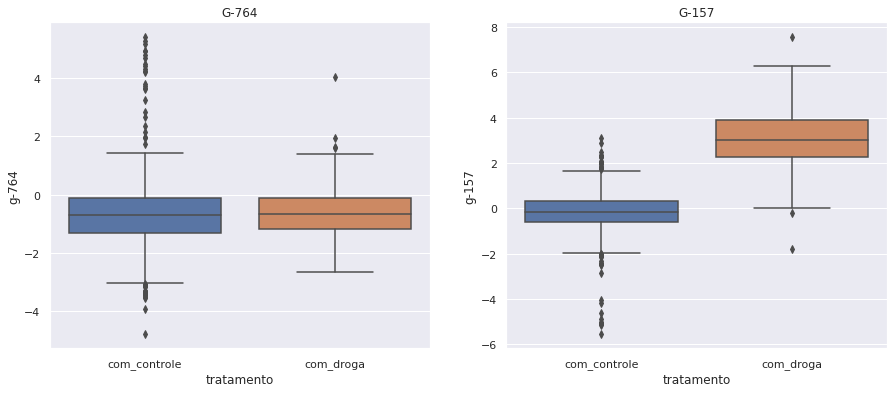

In [9]:
primeiro_acima_controle = composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][maiores_mean].sort_values(ascending=True)[0:1]
maior_acima_controle = composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][maiores_mean].sort_values(ascending=False)[0:1]

print(f"Mais acima da média: {maior_acima_controle.index[0]} --- Primeiro acima da média: {primeiro_acima_controle.index[0]}")

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('G-764')
sns.boxplot(y='g-764', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'))

plt.subplot(1, 2, 2)
plt.title('G-157')
sns.boxplot(y='g-157', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'))
plt.show()

Vamos fazer o mesmo procedimento para os que ficaram abaixo da média.

Quantidade de genes menores que a média: 416
Mais abaixo da média: g-183 --- Primeiro abaixo da média: g-707


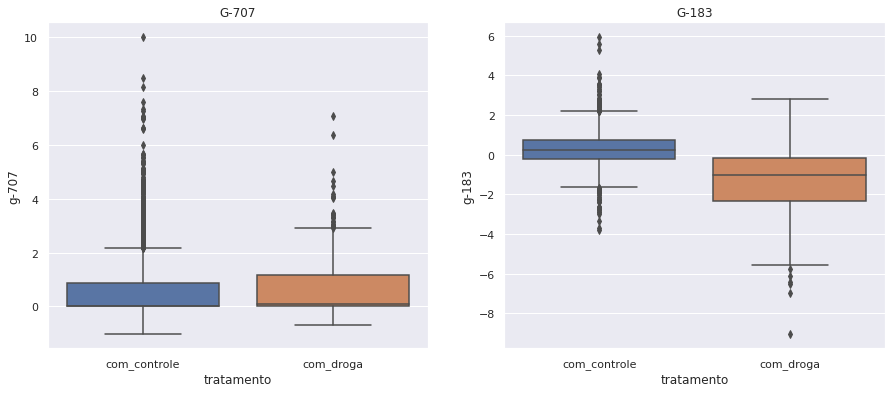

In [10]:
#verifica quais genes possui media menor que o controle
menores_mean = grupo_controle.loc[:,'g-0':'g-771'].describe().T['mean'] > composto_analise.loc[:,'g-0':'g-771'].describe().T['mean']
print(f"Quantidade de genes menores que a média: {len(composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][menores_mean])}")

primeiro_abaixo_controle = composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][menores_mean].sort_values(ascending=False)[0:1]
menor_abaixo_controle = composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][menores_mean].sort_values(ascending=True)[0:1]

print(f"Mais abaixo da média: {menor_abaixo_controle.index[0]} --- Primeiro abaixo da média: {primeiro_abaixo_controle.index[0]}")

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('G-707')
sns.boxplot(y='g-707', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'))

plt.subplot(1, 2, 2)
plt.title('G-183')
sns.boxplot(y='g-183', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'))
plt.show()

Pela análise podemos vê que aqueles que tem valores maiores acima da média tiveram sua expressão aumentada. De maneira análoga aqueles que tiveram valores bem abaixo da média sua expressão diminuiram.

##Quais componentes celulares foram afetados dado um composto.

Aqui vamos fazer de maneira similar aos realizados nos genes. Entranto vamos focar onde a viabilidade foi diminuída, ou seja aqueles componentes celulares que tiveram maior quantidade de células mortas.

Quantidade de componentes menores que a média: 50
Mais abaixo da média: c-59 --- Primeiro abaixo da média: c-51


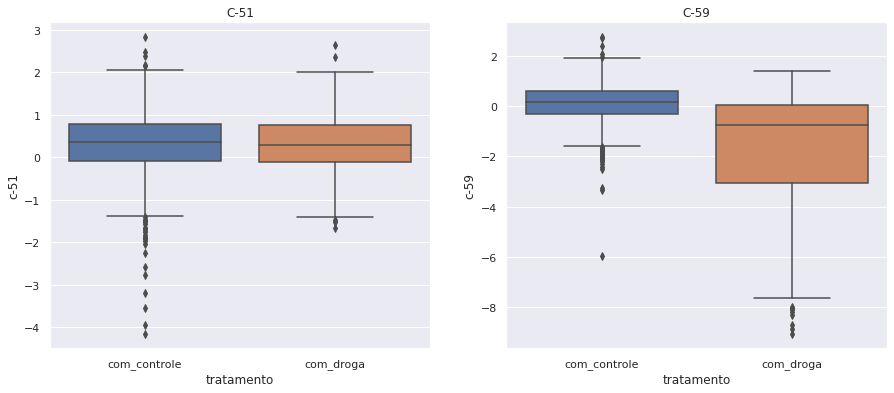

In [11]:
#verifica quais componentes celulares obtiveram medias menores que o controle
menores_mea_cells = grupo_controle.loc[:,'c-0':'c-99'].describe().T['mean'] > composto_analise.loc[:,'c-0':'c-99'].describe().T['mean']
print(f"Quantidade de componentes menores que a média: {len(composto_analise.loc[:,'c-0':'c-99'].describe().T['mean'][menores_mea_cells])}")

primeiro_abaixo_controle_cells = composto_analise.loc[:,'c-0':'c-99'].describe().T['mean'][menores_mea_cells].sort_values(ascending=False)[0:1]
menor_abaixo_controle_cells = composto_analise.loc[:,'c-0':'c-99'].describe().T['mean'][menores_mea_cells].sort_values(ascending=True)[0:1]

print(f"Mais abaixo da média: {menor_abaixo_controle_cells.index[0]} --- Primeiro abaixo da média: {primeiro_abaixo_controle_cells.index[0]}")

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('C-51')
sns.boxplot(y='c-51', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'))

plt.subplot(1, 2, 2)
plt.title('C-59')
sns.boxplot(y='c-59', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'))
plt.show()

Da mesma forma que no genes quanto maior a diferença entre a média do controle maior o impacto. Nesse caso maior a diferença maior quantidade de células mortas.

## A dose e o tempo influenciam nas expressões genéticas e componentes celulares?

Para anarlisarmos essa hipótese vamos utilizar os genes e componentes celulares que fora mais afetados.

Iniciando com o componente celular ```c-59``` em relação ao tempo.

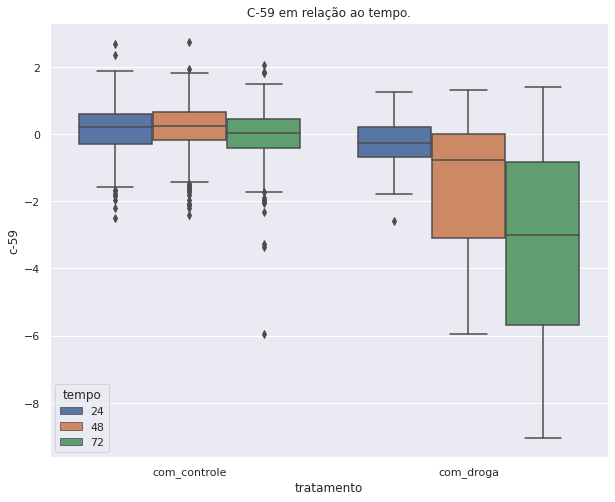

In [12]:
plt.figure(figsize=(10,8))
plt.title('C-59 em relação ao tempo.')
sns.boxplot(y='c-59', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')

Podemos observar que o componente com o tempo de 24 é similar ao grupo de controle e vai diminuindo a medida que o tempo passa.

Vamos observar em relação as doses.

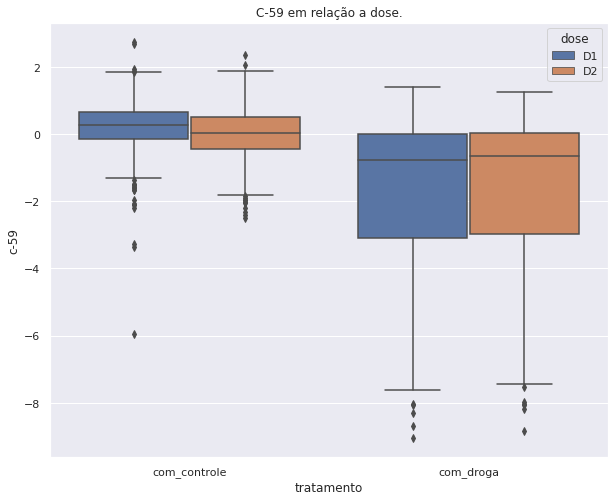

In [13]:
plt.figure(figsize=(10,8))
plt.title('C-59 em relação a dose.')
sns.boxplot(y='c-59', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='dose')

Aparentemente as doses não influenciaram na viabilidade.

Analisando agora as expressões genéticas em relação ao tempo. Vamos observar o ```g-157``` que teve o maior aumento em sua expressão e o ```g-183``` que teve a menor diminuição em sua expressão.

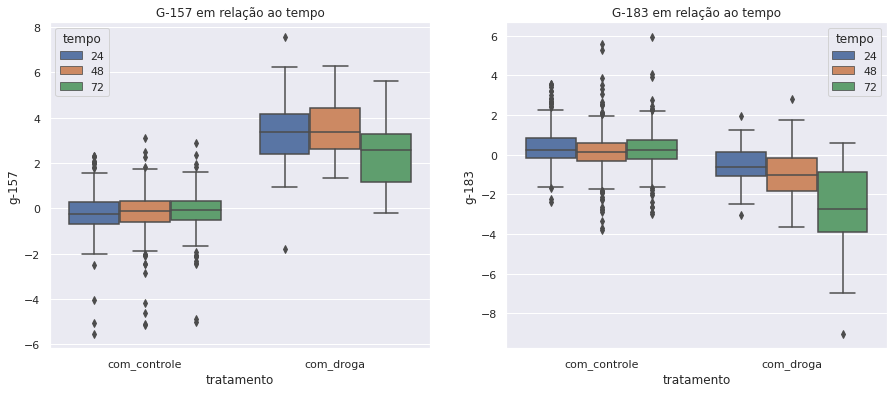

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('G-157 em relação ao tempo')
sns.boxplot(y='g-157', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')

plt.subplot(1, 2, 2)
plt.title('G-183 em relação ao tempo')
sns.boxplot(y='g-183', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')
plt.show()

Olha que interessante, o gene ```g-183``` que obteve maior diferenção na diminuição da sua expressão diminui cada vez mais ao longo do tempo. O ```g-157``` que obteve a maior mas em relação ao aumento de sua expressão, aumenta nos tempos iniciais mais diminui no final. Aqui podemos testar outra hipótese, será que nos genes que tiveram suas expressões aumentadas diminuem com o tempo.

Para isso vamos selecionar agora os quatros maiores e verificar como se comportam em relação ao tempo.

g-157    3.086657
g-178    3.072713
g-100    2.031541
g-156    1.838573
g-48     1.611100
Name: mean, dtype: float64


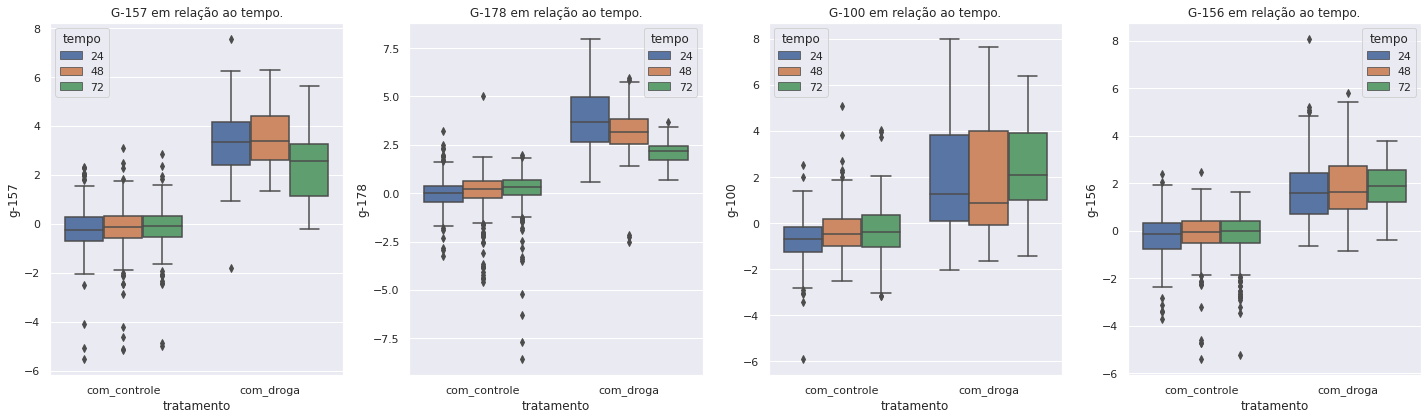

In [15]:
print(composto_analise.loc[:,'g-0':'g-771'].describe().T['mean'][maiores_mean].sort_values(ascending=False)[0:5])

f = plt.figure(figsize=(20, 6))
gs = f.add_gridspec(1, 4)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(y='g-157', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')
    plt.title('G-157 em relação ao tempo.')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(y='g-178', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')
    plt.title('G-178 em relação ao tempo.')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 2])
    sns.boxplot(y='g-100', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')
    plt.title('G-100 em relação ao tempo.')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 3])
    sns.boxplot(y='g-156', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='tempo')
    plt.title('G-156 em relação ao tempo.')
    

f.tight_layout()

A nossa hipótese se mostra presente nos dois genes que obtiveram maiores diferenças e nos outros o tempo aparentemente não influencia. Mas também podemos observar que a diferença nas médias dos dois maiores em relação aos outros parece ser significativa.

Analisando agora as doses nos genes ```g-157``` e ```g-183```.

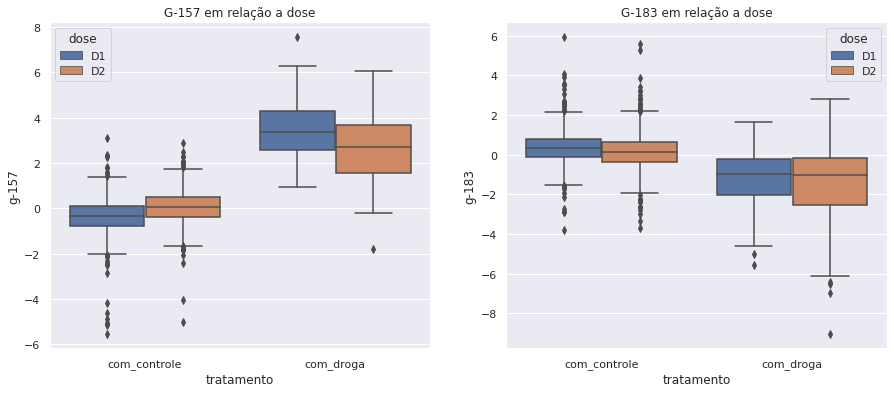

In [16]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('G-157 em relação a dose')
sns.boxplot(y='g-157', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='dose')

plt.subplot(1, 2, 2)
plt.title('G-183 em relação a dose')
sns.boxplot(y='g-183', x='tratamento' , data=base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]'), hue='dose')
plt.show()

Uma análise preliminar seria que para o ```g-157``` os experimentos com dose D2 obtiverem menos expressão que a D1. Já para o ```g-183``` não notou-se influência.

## É possível identificar que mecanismos de ação foram ativados dado os experimentos de um composto?

Para verificar essa hipótese vamos utilizar a ```base_moa``` que contêm as informações dos mecanismos de ativação.

In [17]:
#juncao da base de experimentos e moa 
dados_combinados = pd.merge(base_experimentos[['id','composto']], base_moa, on='id')
#seleciona os dados somente da composto em estudo
dados_combinados = dados_combinados.query('composto == "9f80f3f77"')
#retira as colunas id e composto para somar os valores das colunas
dados_combinados = dados_combinados.drop('id', axis=1)
dados_combinados = dados_combinados.drop('composto', axis=1)

#verifica que colunas tem moa ativos
dados_combinados.T.loc[dados_combinados.T.sum(axis=1) > 0]

,75,251,337,355,404,467,651,929,948,1037,1251,1414,1433,1594,1604,1876,1945,2089,2141,2282,2303,2529,2613,2622,2625,2659,2728,2794,2814,2945,3102,3165,3183,3210,3508,3546,3677,3879,3890,3981,...,19127,19367,19412,19433,19674,19777,19978,20077,20241,20289,20318,20391,20442,20462,20617,20662,20674,20784,20791,20834,20853,21205,21266,21645,22073,22512,22575,22665,22706,22751,23083,23123,23128,23244,23367,23400,23604,23675,23762,23774
hmgcr_inhibitor,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Para esse composto analisado em todos os experimentos foi ativado o mecanismo ```hmgcr_inhibitor``` e somente ele. 

De acordo com a [Santa Cruz Biotechnology](https://www.scbt.com/browse/chemicals-Protein-Interacting-Inhibitors-Activators-Substrates-Protein-Inhibitors-HMGCR-Inhibitors/_/N-cddws3), os inibidores de HMGCR (estatinas) exercem efeitos antiinflamatórios e diminuem a frequência de eventos cardiovasculares ao diminuir o colesterol plasmático.

#Aprendizagem de Máquina

Nesta etapa do projeto vamos aplicar um modelo de aprendizagem de máquina em que são informados somente os atributos das expressões genéticas e os componentes celulares. O objetivo desse modelo é identificar se a amostra possui é composto ou controle.

In [18]:

x = base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]').select_dtypes('float64')
y = base_experimentos.query('composto in ["9f80f3f77", "cacb2b860"]')['composto'] 

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_arvore = DecisionTreeClassifier(max_depth = 3)
modelo_arvore.fit(x_treino, y_treino)
modelo_arvore.score(x_teste, y_teste)

0.9881796690307328

Utilizamos um modelo de aprendizagem simples chamada [Árvore de Decisão](https://scikit-learn.org/stable/modules/tree.html#tree) obtendo uma acurácia de 98%. 

Podemos ainda visualizar a Árvore gerada no treinamento.

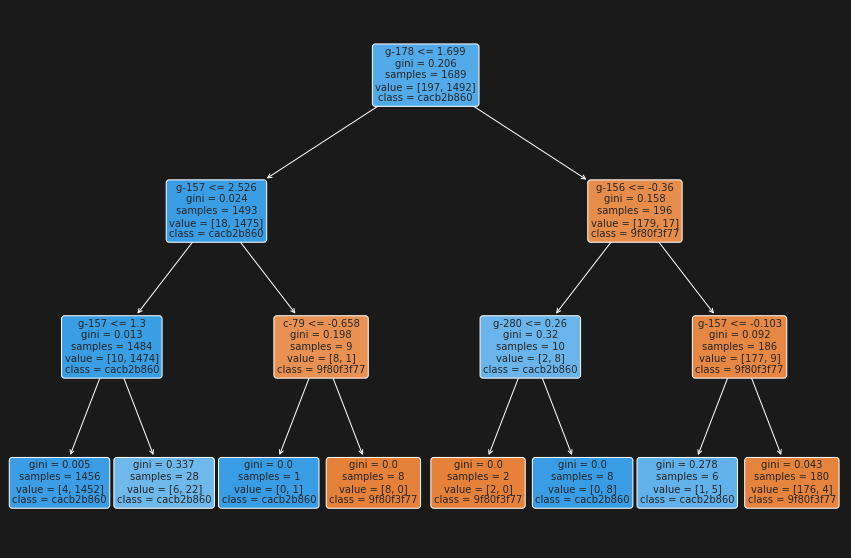

In [19]:

fig, ax = plt.subplots(figsize=(15, 10), facecolor='k')
tree.plot_tree(modelo_arvore,
               ax=ax,
               fontsize=10,
               rounded=True,
               filled=True,
               feature_names=x_treino.columns,
               class_names=['9f80f3f77', 'cacb2b860'])

plt.show()

Observando a árvore podemos ver vários dos genes que apareceram nas nossas análises.

#Conclusões

Por estarmos trabalhando com uma base que possui muitos atributos em alguns casos é importante reduzirmos a dimensionabilidade para melhor compreendê-la.

Inicalmente fizemos uma pausa para entendermos melhor alguns atributos, no casos as expressões genéticas e os componentes celulares.

Também selecionamos apenas um composto para facilitar a análise. Estabalecemos algumas hipóteses e realizamos alguns experimentos para validá-las.

Observamos que alguns genes tiveram suas expressões genéticas modificadas, como é o caso do gene ```g-157``` que aumentou sua expressão e o ```g-183``` que diminuiu. Ainda falando dos genes vimos que o tempo também os influenciam. Para o ```g-183``` quanto maior o tempo mais dimunuia sua expressão, já o ```g-157``` sua expressão aumentava no inicio mas dimuia no final.

Realizamos também uma análise sobre a viabilidade das células, e identificamos quais tiveram sua viabilidade diminuida. Em especial a ```c-59``` que teve a maior diferença na média em relação ao grupo de controle. Foi possível observar melhor quando colocamos a variável tempo, em que observou-se que a medida que o tempo passava menor sua viabilidade.

Na análise dos mecanismos de ação verificamos que para o composto ```9f80f3f77``` ativou o mecanismo ```hmgcr_inhibitor```, esse responsável por efeitos antiinflamatórios.

Ao final aplicamos um modelo de aprendizagem de máquina chamado Árvore de Decisão com resultados de acurácia de 98%.